In [1]:
import numpy as np_ # Original numpy 
import scipy as sp

import random

# Plot
from IPython.display import display, Latex
import matplotlib.pyplot as plt

# PennyLane
import pennylane as qml
from pennylane import numpy as np

# qnode device
dev = qml.device('default.mixed', wires = 1)

# Hamiltonian setup 
coeffs = [1]
obs = [qml.PauliZ(0)]

hamiltonian = qml.Hamiltonian(coeffs, obs)  # Define Hamiltonian

In [2]:
# Global paras 
Tau_global = 5e-2   # Dephase tau
# Tau_global = 1e-100   # Dephase tau
Paras_global, Phi_global, Gamma_ps  = np.zeros(2), 0, 0

def Dephase_factor(tau):
    """ Take tau and return gamma based on the following relation."""

    Calculate_Gamma = 1 - np.exp(-2 * tau)
    
    return Calculate_Gamma    # Return gamma

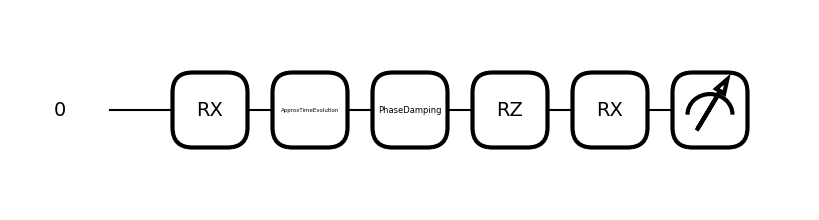

In [3]:
@qml.qnode(dev)
def circuit(paras):
    global Phi_global, Tau_global
    phi = Phi_global
    
    # Set dephase factor 
    gamma_dephase_in = Dephase_factor(Tau_global)  

    theta_x, phi_z = paras[0], paras[1]

    qml.RX(np.pi/2, wires = 0)
    # qml.Hadamard(wires=0)

    qml.ApproxTimeEvolution(hamiltonian, -phi/2, 1)
    qml.PhaseDamping(gamma_dephase_in, wires = 0)

    qml.RZ(phi_z, wires = 0)  # phi_z
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    return qml.density_matrix(wires = 0)


@qml.qnode(dev)
def Post_selection_Dephase(phi):
    """ Take qnode from circuit_1 and calculate decoherence using kraus operator.
    
    Args:
        phi (float): Phi for Time-approximation. Pass by global variables:'Phi_global'

    Returns:
        qml.density_matrix: Density matrix of full qnode
    """
    
    global Paras_global, Phi_global, Gamma_ps
    Phi_global = phi
    
    # Get density matrix from circuit_1
    density_matrix = circuit(Paras_global)
    qml.QubitDensityMatrix(density_matrix, wires = 0)
    
    # Kraus operator for 2*2 matrix
    K = np.array([ [np.sqrt(1 - Gamma_ps), 0], [0, 1] ])
    
    Numerator = K @ density_matrix @ K.conj().T
    Denominator = np.trace(K @ density_matrix @ K.conj().T)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = 0)
    
    return qml.density_matrix(wires = 0) 

paras_plot = 1,1
fig, ax = qml.draw_mpl(circuit)(paras_plot)

In [4]:
def Cost_function(paras):
    """ Calculate Classical-Fisher-Information for qnode(=Post_selection_Dephase).
    
    Args:
        paras (Numpy array): [theta_init, tau_1, tau_2, tau_d1, tau_d2, tau_d3]

    Returns:
        _type_: CFI with minus(-) sign.
    """
    
    global Paras_global, Phi_global
    Paras_global, phi = paras, np.array([Phi_global])
          
    CFI = qml.qinfo.classical_fisher(Post_selection_Dephase)(phi[0])
    
    return -CFI

In [5]:
paras_tt = np_.array([5,5.60603193e+00])
-Cost_function(paras_tt).squeeze()

0.6604092698880913

In [6]:
# == BFGS -> Return Data_set:[phi, CFI, 6-Paras] ==
def BFGS(Sweep_Data, paras, gamma_ps_select, Iterations):
    """ Perform maximum optimization using the L-BFGS-B algorithm.

    Args:
        Sweep_Data (numpy_array): Range of data sweeps.
        paras (numpy_array): Array of 3 parameters for the qnode.
        gamma_ps_select (int): The Gamma value for post-selection.
        Iterations (int): Number of iterations for the optimization.

    Returns:
        Numpy array: 3-Dimension Data array
    """
    
    # Create Data array
    PHI = np_.arange(Sweep_Data[0], Sweep_Data[1], Sweep_Data[2]).reshape(-1, 1)
    Data = np_.zeros((Iterations + 1, len(PHI), len(paras) + 2)) 
    
    Data[:, :, 0] = PHI.squeeze() # Append PHI in to 0th col
    
    # INDEX CONSTANT
    CFI_INDEX, PARAS_INDEX, BEFORE_OPT_LAYER_INDEX = 1, 2, 0
    
    # Set global variables
    global Gamma_ps, Phi_global, Paras_global
    Gamma_ps = gamma_ps_select 
    
    # Declare Paras temp 
    Paras_Temporary = 0
    
    # Before optimization; CFI data
    for Phi_Index in range(len(PHI)):
        Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][CFI_INDEX] = -Cost_function(paras)
        
        for Paras_Index_Array in range(len(paras)):
            Data[BEFORE_OPT_LAYER_INDEX][Phi_Index][PARAS_INDEX + Paras_Index_Array] = paras[Paras_Index_Array]
        
        
    # Optimize begin
    for Layer_Index in range(1, Iterations + 1):
        for Phi_Index in range(len(PHI)):
            # Load previous paras
            Paras_Temporary = paras if Layer_Index == 1 else Data[Layer_Index][Phi_Index][PARAS_INDEX:]
            
            # Set Phi(Currently sweeping)
            Phi_global = Data[Layer_Index][Phi_Index][0]
            
            # Constraints(gamma = 0.99..) 
            tau_upper = 18
            Constraints = [(-float('inf'), float('inf'))] * 2 
            
            # Push paras to global var
            Paras_global = Paras_Temporary
            Result_BFGS = sp.optimize.minimize(Cost_function, Paras_Temporary, method = 'SLSQP', bounds = Constraints)
            Data[Layer_Index][Phi_Index][CFI_INDEX] = -Result_BFGS.fun
            
            # Store data in array
            for Paras_Index_Array in range(len(Paras_Temporary)):
                Data[Layer_Index][Phi_Index][PARAS_INDEX + Paras_Index_Array] = Result_BFGS.x[Paras_Index_Array]
            
    return Data

In [7]:
# == Fixed to gamma_ps = 0.8 ==

# == Sweep for 0 ~ pi*3 == 
Step = np.pi / 25     #1e-1
# Step = 1e-2
Sweep_data = np_.array([1e-4, np.pi * 2 + 1e-4, Step])

Paras_init = np.zeros(2)
Paras_init[:2] = random.uniform(3, 6)

Gamma_ps_preset = 0.8
Set_Iterations = 3

Optimized_Result = BFGS(Sweep_data, Paras_init, Gamma_ps_preset, Set_Iterations)

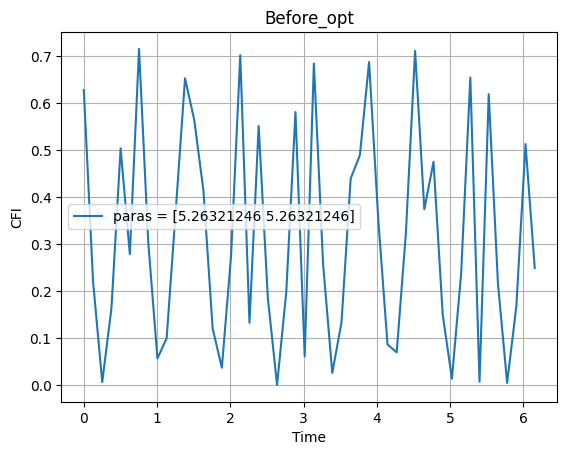

In [8]:
Sweep_data_arange = np_.arange(1e-4, np.pi * 2 + 1e-4, np.pi / 25)
data_before = np_.zeros(len(Sweep_data_arange))

# Para_init
# Paras_global = np.array([3.4, 3.4])
Paras_global = Paras_init

for i in range(len(Sweep_data_arange)):
    conversion = np.array([i])
    data_before[i] = qml.qinfo.classical_fisher(Post_selection_Dephase)(conversion[0])
    conversion = 0
    
plt.plot(Sweep_data_arange, data_before, label = f'paras = {Paras_init}')
plt.title(f'Before_opt')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid() 

In [9]:
type(Paras_global)

pennylane.numpy.tensor.tensor

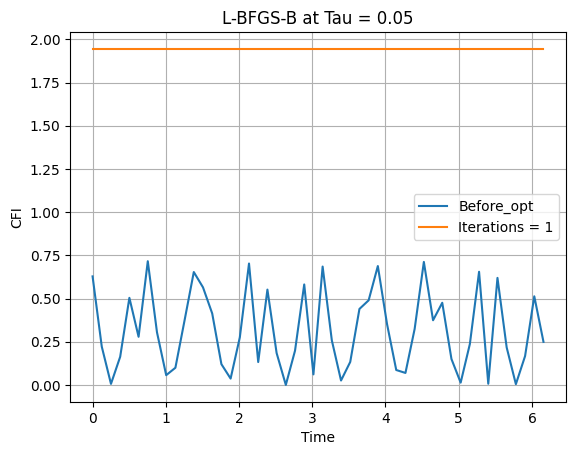

In [10]:
plt.plot(Sweep_data_arange, data_before, label = f'Before_opt')

plt.plot(Optimized_Result[0, :, 0], Optimized_Result[1, :, 1], label = f'Iterations = 1')
    
plt.title(f'L-BFGS-B at Tau = {Tau_global}')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.legend()
plt.grid() 

In [11]:
# Optimized_Result[0, :,:].squeeze()

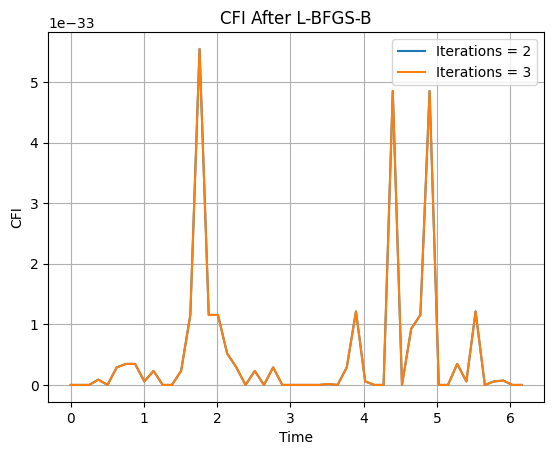

In [12]:
Target_Layer = 2,3
plt.plot(Optimized_Result[Target_Layer[0], :, 0], Optimized_Result[Target_Layer[0], :, 1], 
         label = f'Iterations = {Target_Layer[0]}')

plt.plot(Optimized_Result[Target_Layer[1], :, 0], Optimized_Result[Target_Layer[1], :, 1], 
         label = f'Iterations = {Target_Layer[1]}')

plt.title('CFI After L-BFGS-B')
plt.xlabel('Time')
plt.ylabel('CFI')

plt.legend()
plt.grid() 

In [13]:
Optimized_Result[1][:, :]

array([[1.00000000e-04, 1.94429675e+00, 4.71239053e+00, 5.81175542e+00],
       [1.25763706e-01, 1.94429674e+00, 4.71238214e+00, 5.93741017e+00],
       [2.51427412e-01, 1.94429674e+00, 4.71239884e+00, 6.06309540e+00],
       [3.77091118e-01, 1.94429675e+00, 4.71238839e+00, 6.18875217e+00],
       [5.02754825e-01, 1.94429675e+00, 4.71238963e+00, 6.31440872e+00],
       [6.28418531e-01, 1.94429633e+00, 4.71259152e+00, 6.44013343e+00],
       [7.54082237e-01, 1.94429674e+00, 4.71238127e+00, 6.56576109e+00],
       [8.79745943e-01, 1.94429675e+00, 4.71238846e+00, 6.69140409e+00],
       [1.00540965e+00, 1.94429644e+00, 4.71234333e+00, 6.81688312e+00],
       [1.13107336e+00, 1.94429672e+00, 4.71243769e+00, 6.94276182e+00],
       [1.25673706e+00, 1.94429675e+00, 1.57078815e+00, 1.11530477e+01],
       [1.38240077e+00, 1.94429672e+00, 4.71235135e+00, 7.19409638e+00],
       [1.50806447e+00, 1.94429674e+00, 4.71241254e+00, 8.26276986e+00],
       [1.63372818e+00, 1.94429674e+00, 4.71240254e